In [1]:
using StateSpaceDynamics, Plots

In [2]:
model = initialize_slds()

SwitchingLinearDynamicalSystem([0.95 0.05; 0.05 0.95], StateSpaceDynamics.LinearDynamicalSystem[StateSpaceDynamics.LinearDynamicalSystem{StateSpaceDynamics.GaussianStateModel{Float64}, StateSpaceDynamics.GaussianObservationModel{Float64}}(StateSpaceDynamics.GaussianStateModel{Float64}([0.9452539570141245 -0.09484174581448675; 0.09484174581448675 0.9452539570141245], [0.1 0.0; 0.0 0.1], [0.0, 0.0], [0.1 0.0; 0.0 0.1]), StateSpaceDynamics.GaussianObservationModel{Float64}([-0.31498797116895605 0.4338858743048611; -0.31125240132442067 -0.3954398407537453; … ; -0.8253345499750688 -0.9654904870197227; 0.840288523245819 0.9656607495563969], [0.5 0.0 … 0.0 0.0; 0.0 0.5 … 0.0 0.0; … ; 0.0 0.0 … 0.5 0.0; 0.0 0.0 … 0.0 0.5]), 2, 10, Bool[1, 1, 1, 1, 1, 1]), StateSpaceDynamics.LinearDynamicalSystem{StateSpaceDynamics.GaussianStateModel{Float64}, StateSpaceDynamics.GaussianObservationModel{Float64}}(StateSpaceDynamics.GaussianStateModel{Float64}([-0.39533949471978524 -0.8638325554843976; 0.8638325

In [3]:
T = 1000
# Generate synthetic data
x, y, z = sample(model, T)


([0.12781148406102946 -0.4355143368251308 … 0.1018167508642654 0.32258504931040094; 0.3788281101630884 -0.21698572664429974 … -0.7614759222798447 -0.9851267235719199], [-0.23695130919359814 0.19690226661132149 … -1.0595318983866 -0.39005476383921234; 0.6768781267756329 0.41107216802264435 … 0.2702841179302868 1.0778344400245188; … ; -0.7985358658347501 1.2320332201982314 … 2.057440153033145 -0.3122152790649294; 0.35633628786769284 -1.54937097407612 … -0.4712289915268464 -0.877337481844187], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

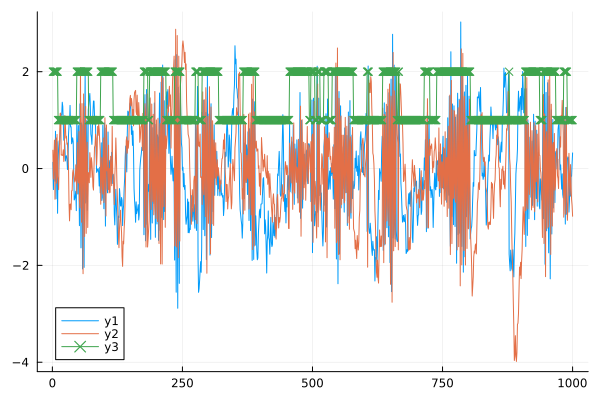

In [4]:
plot(x')
plot!(z, marker=:x)

Fit and get back posteriors

In [12]:
mls, param_diff, FB, FS = fit!(model, y; max_iter=2)

([-39530.607322378324, -3.393252724226477e79], [0.0, 0.0], StateSpaceDynamics.ForwardBackward{Float64}([-25.419468578340112 -9.070038673372302 … -2.0122071624830022 -4.804447761610589; -2.9126362341260186 -2.4094772733714627 … -8.502961348940396 -14.070854022099164], [-44.53438481029809 -11.21597861670195 … 14563.45399523689 14559.275933877007; -2.9126362391209635 -4.55541721670111 … 14556.963241050433 14550.00952761652], [14562.046607267956 14563.688277999867 … -4.179714313895386 0.0; 14562.188664659247 14563.830335391158 … -4.037656922604846 0.0], [-41.76380596246781 -6.803729036959339 … -0.0017474972264608368 -9.454321480006911e-5; 0.0 -0.0011102456683147466 … -6.350444292393149 -9.266500803702002], [0.0 0.0; 0.0 0.0;;; 0.0 0.0; 0.0 0.0;;; 0.0 0.0; 0.0 0.0;;; … ;;; 0.0 0.0; 0.0 0.0;;; 0.0 0.0; 0.0 0.0;;; 0.0 0.0; 0.0 0.0]), StateSpaceDynamics.FilterSmooth{Float64}[StateSpaceDynamics.FilterSmooth{Float64}([-0.30734800084180913 -0.2841403234715364 … 0.09005144221122299 0.3124786471347

In [13]:
mls

2-element Vector{Float64}:
 -39530.607322378324
     -3.393252724226477e79

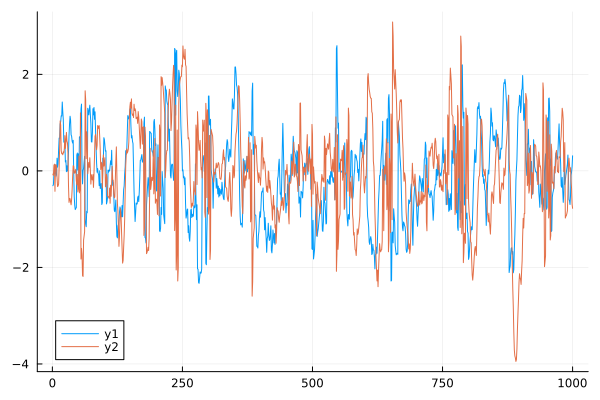

In [15]:
plot(FS[1].x_smooth')

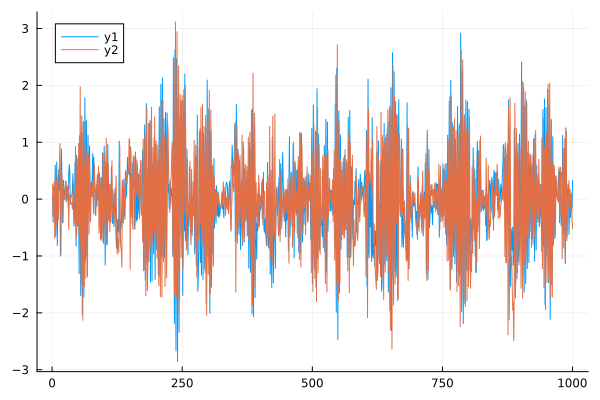

In [16]:
plot(FS[2].x_smooth')

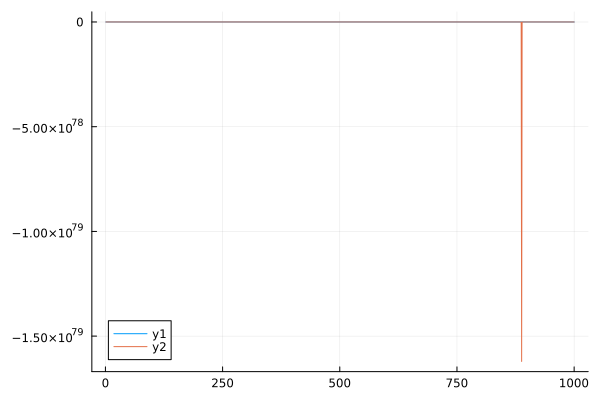

In [20]:
plot(FB.γ')

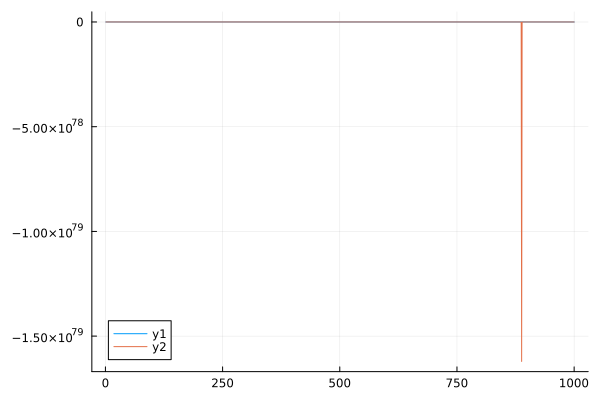

In [23]:
plot(FB.loglikelihoods')